In [8]:
%reload_ext autoreload
%autoreload 2

#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm

import os
repo_path = os.path.abspath("../")

import sys
sys.path.insert(0, repo_path)

from model_functions_initial.utility import utility_functions
from model_functions_initial.final_period_utility import final_period_utility
from model_functions_initial.budget import budget_dcegm_initial
from model_functions_initial.state_space_functions import create_state_space_function_dict
from model_functions_initial.compute_moments import compute_simulation_moments
from model_functions_initial.compute_moments import compute_simulation_moments_with_ci
from plots.plots import plot_empirical_vs_simulated_with_ci
from model_functions_initial.estimation import estimate_msm
from first_step.load_params import load_params_txt
from model_functions_counter.compute_counterfac import compute_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_cf_diff_separate
from model_functions_counter.compute_counterfac import compute_diff_by_edu
from model_functions_counter.compute_counterfac import plot_metrics_individual

from model_functions_counter.budget_counter import budget_dcegm_counter_oap

from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = repo_path + "/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash 47f27e8 #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

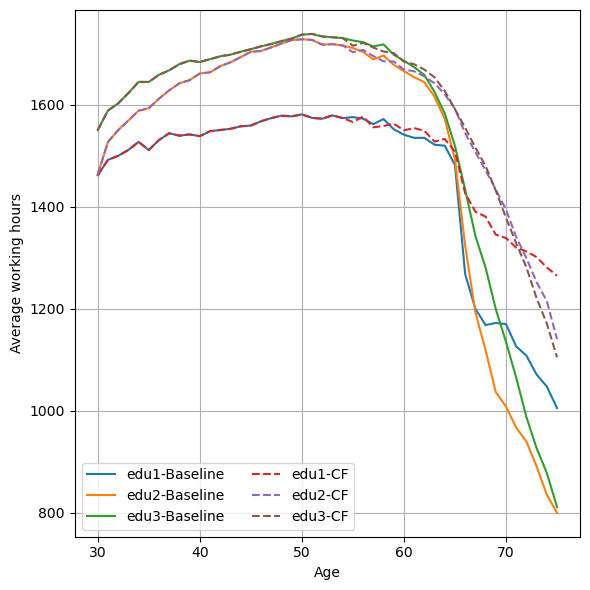

In [2]:
BASE = repo_path + "/oap_counterfactuals/unexpected"
edus = ["edu1","edu2","edu3"]

# 1) Load into dictionaries
moments = {}
for edu in edus:
    moments[edu] = {}
    init_path = os.path.join(BASE, f"moments_init_{edu}.pkl")
    cf_path   = os.path.join(BASE, f"moments_cf_{edu}.pkl")
    
    if os.path.exists(init_path):
        moments[edu]["init"] = pd.read_pickle(init_path)
    else:
        print(f"Warning: File not found: {init_path}")
        moments[edu]["init"] = pd.DataFrame()  # Initialize with an empty DataFrame
    
    if os.path.exists(cf_path):
        moments[edu]["cf"] = pd.read_pickle(cf_path)
    else:
        print(f"Warning: File not found: {cf_path}")
        moments[edu]["cf"] = pd.DataFrame()  # Initialize with an empty DataFrame

# 2) Tag & concat into one DataFrame per scenario
df_init = pd.concat(
    [moments[edu]["init"].assign(edu=edu) for edu in edus],
    ignore_index=True
)
df_cf   = pd.concat(
    [moments[edu]["cf"].assign(edu=edu)   for edu in edus],
    ignore_index=True
)

# 3) Plot avg_hours by edu & scenario
fig, ax = plt.subplots(figsize=(6,6))
for scenario, df in [("Baseline", df_init), ("CF", df_cf)]:
    for edu, grp in df.groupby("edu"):
        ax.plot(
            grp["age"], grp["avg_hours"],
            label=f"{edu}-{scenario}",
            linestyle="-" if scenario=="Baseline" else "--"
        )
ax.set_xlabel("Age")
ax.set_ylabel("Average working hours")
ax.legend(ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

In [9]:
metrics = ["avg_hours", "avg_wealth", "avg_consumption", "prob_work"]
df_diff_all = compute_diff_by_edu(df_init, df_cf, metrics)

df_diff_all

,edu,age,avg_hours_diff,avg_hours_pct,avg_wealth_diff,avg_wealth_pct,avg_consumption_diff,avg_consumption_pct,prob_work_diff,prob_work_pct
0,edu1,30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,edu1,31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,edu1,32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,edu1,33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,edu1,34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
133,edu3,71,263.505470,24.755481,3.965375,16.172814,0.183089,6.751888,0.165085,40.888129
134,edu3,72,293.323994,29.705744,5.017210,20.884442,0.177053,6.818923,0.159398,45.399144
135,edu3,73,294.028820,31.746640,5.903325,25.114452,0.165581,6.681069,0.139683,45.933784
136,edu3,74,292.899833,33.368335,6.646326,28.977950,0.151675,6.439258,0.116357,43.703296


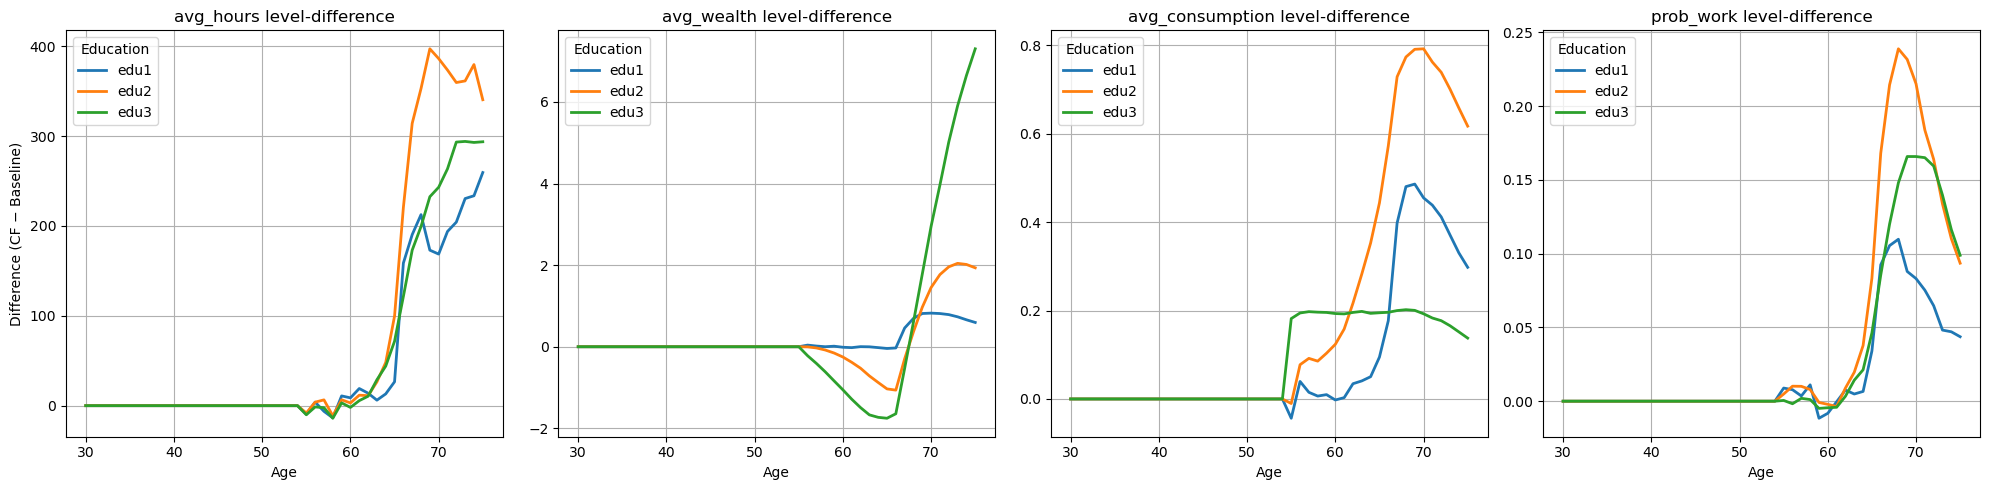

In [4]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    for edu in edus:
        sub = df_diff_all[df_diff_all["edu"] == edu]
        ax.plot(sub["age"], sub[f"{m}_diff"], lw=2, label=edu)
    ax.set_title(f"{m} level‐difference")
    ax.set_xlabel("Age")
    ax.grid(True)
    ax.legend(title="Education")

axes[0].set_ylabel("Difference (CF − Baseline)")
plt.tight_layout()
plt.show()

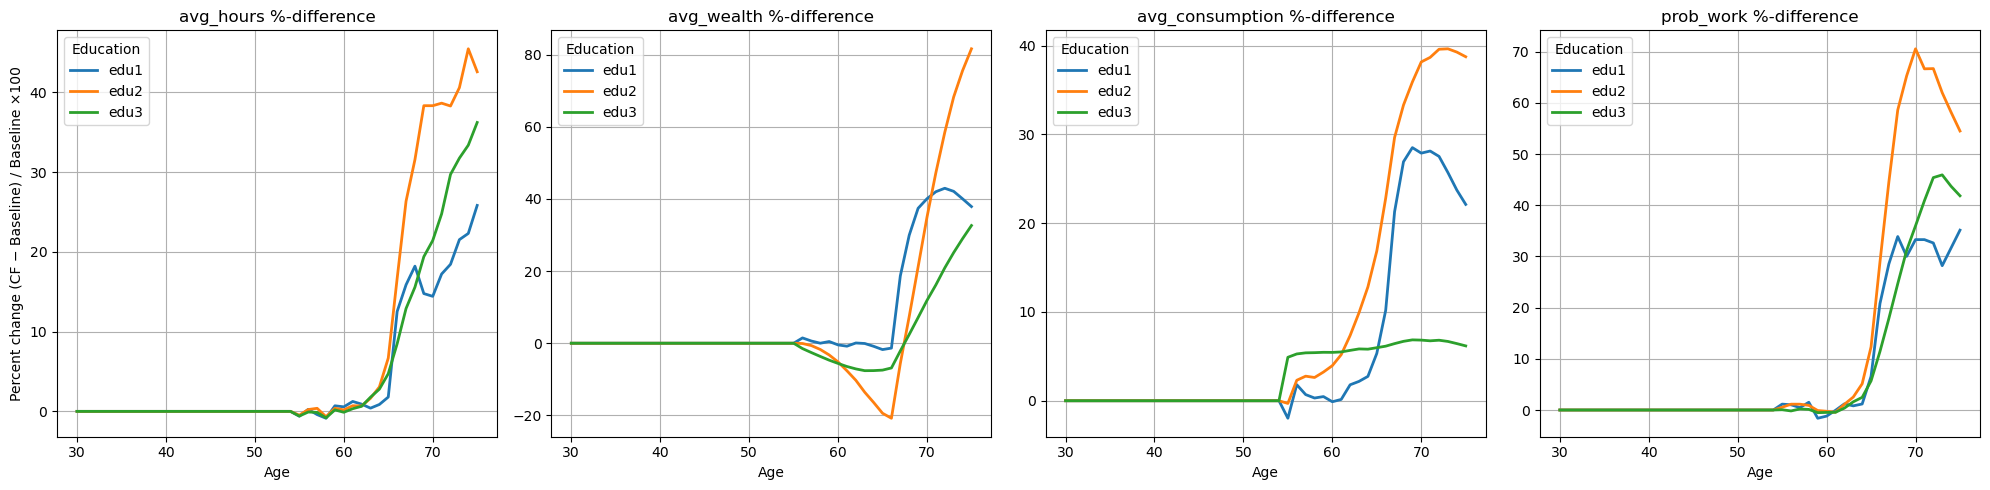

In [5]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    for edu in edus:
        sub = df_diff_all[df_diff_all["edu"] == edu]
        ax.plot(sub["age"], sub[f"{m}_pct"], lw=2, label=edu)
    ax.set_title(f"{m} %‐difference")
    ax.set_xlabel("Age")
    ax.grid(True)
    ax.legend(title="Education")

axes[0].set_ylabel("Percent change (CF − Baseline) / Baseline ×100")
plt.tight_layout()
plt.show()

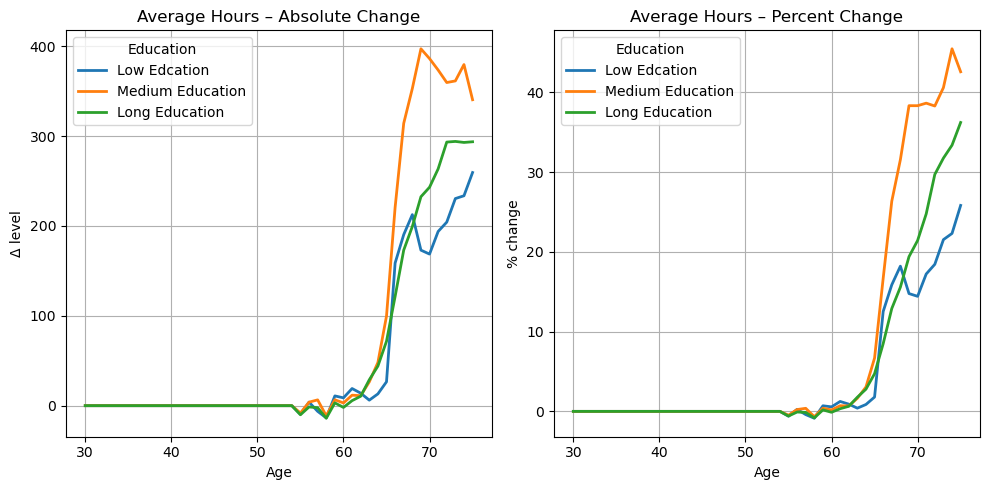

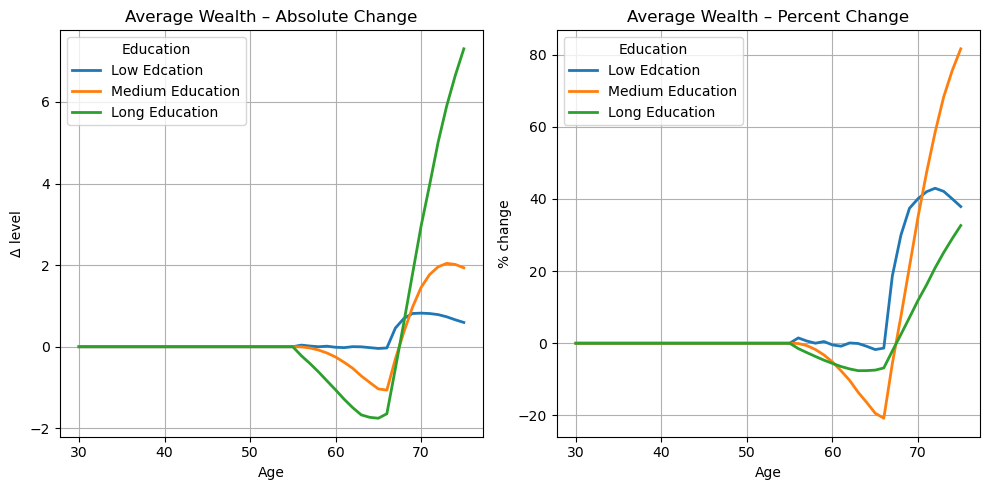

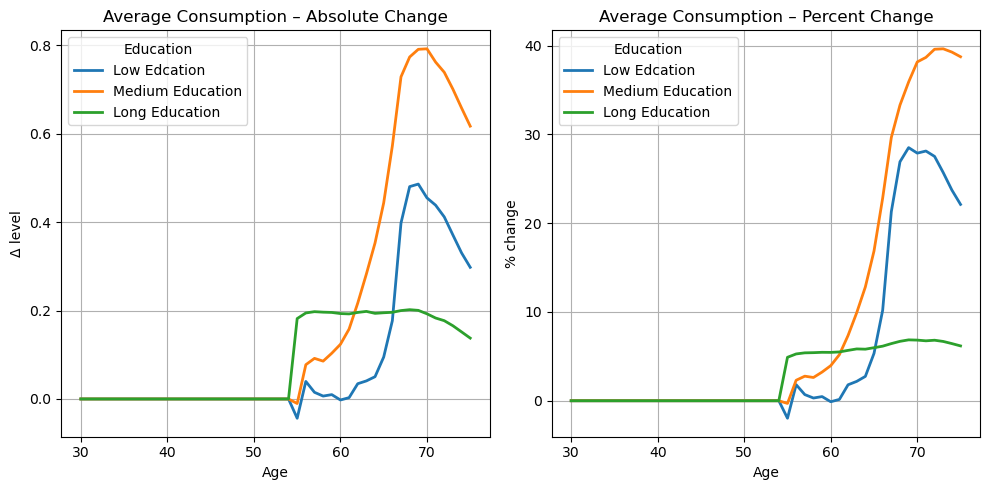

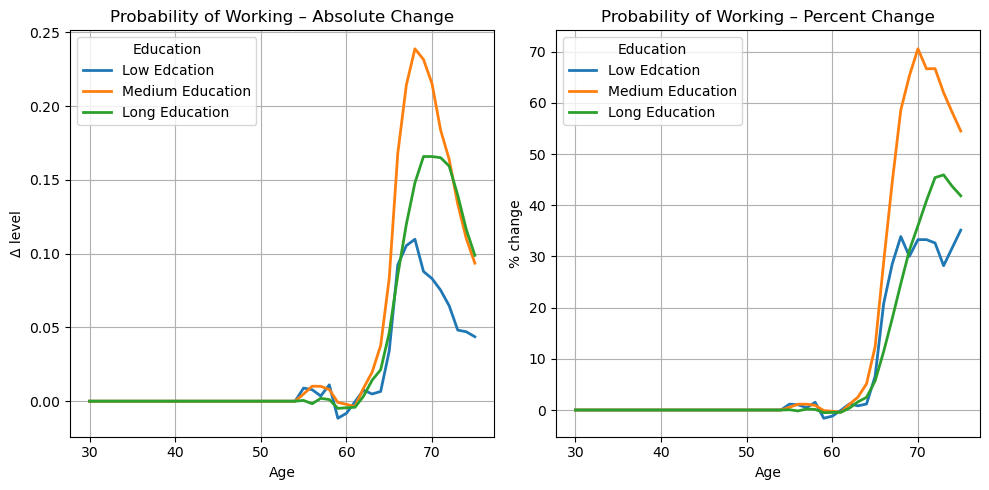

In [13]:
# # The list of moments you care about
# metrics = ["avg_hours", "avg_wealth", "avg_consumption", "prob_work"]

# # df_diff_all must already exist in your namespace
# df = df_diff_all.copy()
# edus = df["edu"].unique()

# # Create subplots: one row per metric, two columns
# fig, axes = plt.subplots(len(metrics), 2, figsize=(10, 4 * len(metrics)), sharex=True)

# # Ensure axes is 2D (even if len(metrics)==1)
# axes = np.atleast_2d(axes)

# for i, metric in enumerate(metrics):
#     ax_abs, ax_pct = axes[i]

#     # Plot each education group
#     for edu in edus:
#         sub = df[df["edu"] == edu]
#         ax_abs.plot(sub["age"], sub[f"{metric}_diff"], lw=2, label=edu)
#         ax_pct.plot(sub["age"], sub[f"{metric}_pct"],  lw=2, label=edu)

#     # Absolute change
#     ax_abs.set_title(f"{metric} – Absolute change")
#     ax_abs.set_ylabel("Δ level")
#     ax_abs.grid(True)
#     if i == 0:
#         ax_abs.legend(title="Education")

#     # Percent change
#     ax_pct.set_title(f"{metric} – Percent change")
#     ax_pct.set_ylabel("% change")
#     ax_pct.grid(True)
#     if i == 0:
#         ax_pct.legend(title="Education")

# # Common X label
# for ax in axes[-1]:
#     ax.set_xlabel("Age")

# plt.tight_layout()
# plt.show()

metric_labels = {
    "avg_hours":       "Average Hours",
    "avg_wealth":      "Average Wealth",
    "avg_consumption": "Average Consumption",
    "prob_work":       "Probability of Working"
}
edu_labels = {
    "edu1": "Low Edcation",
    "edu2": "Medium Education",
    "edu3": "Long Education"
}

plot_metrics_individual(
    df_diff_all,
    metrics,
    edu_labels=edu_labels,
    metric_labels=metric_labels,
    figsize=(10, 5)
)